In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal # used to round the numbers so they look pretty

As an extension from the basic SEIR model, we now assume that a bird in flock $i$ a probability $p_{Si}$ to be symptomatic and $p_{Ai} = 1 - p_{Si}$ to be asymptomatic after being infected.

Set the number of flocks in consideration and the population size in each flock as per the basic case.

In [2]:
# set number of species and population size

num_flocks = 3 # number of flocks
tot_popul = [500] * num_flocks # population size for each flock as a list


Set Initial conditions. The default assumes that all flocks are susceptible except for the 0th one which has one symptomatic exposed bird. Subscript _S means symptomatic and _A means asymtomatic.

In [3]:
# set initial conditions, row represents which species, column represents S, E_S, E_A, I_S, I_A, or R

# set size of matrix
init_val = np.zeros((num_flocks, 6)) # matrix size changes to nx6 because we now have two extra compartments per flock

# first set initial population to be all susceptible
init_val[:, 0] = tot_popul
    
# then let species 0 have one exposed
init_val[0, 0] -= 1
init_val[0, 1] += 1


In [4]:
# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 500000

# set the time and state sequence
t = [0] + [None] * max_events
y = [init_val] + [None] * max_events


The parameters are as follows:

$\beta_{Sij}$: The rate of infection from symptomatic birds from flock $i$ to flock $j$.

$\beta_{Aij}$: The rate of infection from asymptomatic birds from flock $i$ to flock $j$.

$\sigma_{Si}$: Inverse of latency period of symptomatic birds from flock $i$.

$\sigma_{Ai}$ Inverse of latency period of asymptomatic birds from flock $i$.

$\gamma_{Si}$: Inverse of infectious period of symptomatic birds from flock $i$.

$\gamma_{Ai}$: Inverse of infectious period of asymptomatic birds from flock $i$.

$p_{Si}$: Probability of a given infection being symptomatic in flock $i$.

$p_{Ai}$: Probability of a given infection being asymptomatic in flock $i$.

In the code, all $\beta_{ij}$ parameters are packed in a matrix, and all $\sigma_i$, $\gamma_i$, and $p_i$ parameters are packed in a vector array.


In [5]:
# set parameters

# probability of displaying symptoms.
#p_S = np.array([0.8] * num_flocks)
p_S = np.array([0.99, 0.2, 0.95])
p_A = np.ones(num_flocks) - p_S

# infection rate 
# symptomatic
within_flock_S = 2
between_flock_S = 0.001
beta_S = np.diag([within_flock_S - between_flock_S] * num_flocks) + np.ones((num_flocks, num_flocks)) * between_flock_S # how ROW i infects COLUMN j

# asymptomatic
within_flock_A = 1.5
between_flock_A = 0.0002
beta_A = np.diag([within_flock_A - between_flock_A] * num_flocks) + np.ones((num_flocks, num_flocks)) * between_flock_A # how ROW i infects COLUMN j

# latency and infectious period
latency_period_S = 1 * np.ones(num_flocks)
sigma_S = np.ones(num_flocks) / latency_period_S
latency_period_A = 1 * np.ones(num_flocks)
sigma_A = np.ones(num_flocks) / latency_period_A

infectious_period_S = 4 * np.ones(num_flocks)
gamma_S = np.ones(num_flocks) / infectious_period_S
infectious_period_A = 4 * np.ones(num_flocks)
gamma_A = np.ones(num_flocks) / infectious_period_A


We implement the Gillespie algorithm to generate the output. The update rules for a flock $i$ are given as follows:
$$ \begin{align*}
S_i &\xrightarrow{ p_{Si} \sum_{j} \frac{1}{N_j} (\beta_{Sji} I_{Sj} + \beta_{Aji} I_{Aj})}E_{Si} \\
S_i &\xrightarrow{ p_{Ai} \sum_{j} \frac{1}{N_j} (\beta_{Sji} I_{Sj} + \beta_{Aji} I_{Aj})}E_{Ai} \\
E_{Si} &\xrightarrow{\sigma_{Si}} I_{Si} \\
E_{Ai} &\xrightarrow{\sigma_{Ai}} I_{Ai} \\
I_{Si} &\xrightarrow{\gamma_{Si}} R_i \\
I_{Ai} &\xrightarrow{\gamma_{Ai}} R_i 
\end{align*}
$$

The update rules are described in a event matrix. Specifically, let $\textbf{S} = [S_1, \ldots, S_n]$, $\textbf{E}_S = [E_{S1}, \ldots, E_{Sn}]$, $\textbf{I}_S = [I_{S1}, \ldots, I_{Sn}]$, $\textbf{R} = [R_1, \ldots, R_n]$ (similarly for asymptomatic compartments). The update rules can be written (and implemented below) as:

$$ \begin{align*}
\textbf{S} &\xrightarrow{\textbf{p}_S((\textbf{I}_S⊘\textbf{N})B_S)+(\textbf{I}_A⊘\textbf{N})B_A)} \textbf{E}_S \\
\textbf{S} &\xrightarrow{\textbf{p}_A((\textbf{I}_S⊘\textbf{N})B_S)+(\textbf{I}_A⊘\textbf{N})B_A)} \textbf{E}_A \\
\textbf{E}_S &\xrightarrow{\Sigma_S} \textbf{I}_S \\
\textbf{E}_A &\xrightarrow{\Sigma_A} \textbf{I}_A \\
\textbf{I}_S &\xrightarrow{\Gamma_S} \textbf{R} \\
\textbf{I}_A &\xrightarrow{\Gamma_A} \textbf{R}
\end{align*}
$$

where $B, \Sigma, \Gamma$ are the beta matrix, sigma vector array, and gamma vector array respectively.

In [6]:
# run Gillespie

num_event = 0
current_val = init_val.copy()

while (num_event < max_events) and (np.sum(current_val[:,1:5]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
     
    num_event += 1

    ##### create an event matrix ####

    all_events = np.zeros((num_flocks, 6)) # six types of update rules in total

    # this is implemented according to the markdown above
    all_events[:, 0] = np.multiply((current_val[:, 3] / tot_popul) @ beta_S + (current_val[:, 4] / tot_popul) @ beta_A, p_S * current_val[:, 0])
    all_events[:, 1] = np.multiply((current_val[:, 3] / tot_popul) @ beta_S + (current_val[:, 4] / tot_popul) @ beta_A, p_A * current_val[:, 0])
    all_events[:, 2] = np.multiply(sigma_S, current_val[:, 1]) 
    all_events[:, 3] = np.multiply(sigma_A, current_val[:, 2])
    all_events[:, 4] = np.multiply(gamma_S, current_val[:, 3])
    all_events[:, 5] = np.multiply(gamma_A, current_val[:, 4])

    # store total rate to rescale later
    tot_rate = np.sum(all_events)
    
    # do a time leap
    
    r1 = np.random.uniform()
    t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
    
    # then choose events, first choose the type of events (S to E_S, S to E_A, E_S to I_S, E_A to I_A, I_S to R, or I_A to R)
    
    r2 = np.random.uniform()

    if r2 < np.sum(all_events[:, 0]) / tot_rate:
        type_event = 0
    elif r2 < np.sum(all_events[:, 0:2]) / tot_rate:
        type_event = 1
    elif r2 < np.sum(all_events[:, 0:3]) / tot_rate:
        type_event = 2
    elif r2 < np.sum(all_events[:, 0:4]) / tot_rate:
        type_event = 3
    elif r2 < np.sum(all_events[:, 0:5]) / tot_rate:
        type_event = 4
    else:
        type_event = 5
    
        
    # then choose which flock gets updated
    
    r3 = np.random.uniform()
    spec_event_rate = np.sum(all_events[:, type_event]) # total rate of a specific event occurring

    
    for i in range(num_flocks):
        if r3 < np.sum(all_events[0:i+1, type_event]) / spec_event_rate:
            if type_event == 0:
                current_val[i, 0] -= 1
                current_val[i, 1] += 1
            elif type_event == 1:
                current_val[i, 0] -= 1
                current_val[i, 2] += 1
            elif type_event == 2:
                current_val[i, 1] -= 1
                current_val[i, 3] += 1
            elif type_event == 3:
                current_val[i, 2] -= 1
                current_val[i, 4] += 1
            elif type_event == 4:
                current_val[i, 3] -= 1
                current_val[i, 5] += 1
            else:
                current_val[i, 4] -= 1
                current_val[i, 5] += 1
            break
    
    y[num_event] = current_val.copy()

# get rid of none value if there is any:
t = np.array(t[0:num_event+1])
y = np.array(y[0:num_event+1])



Plot the output:

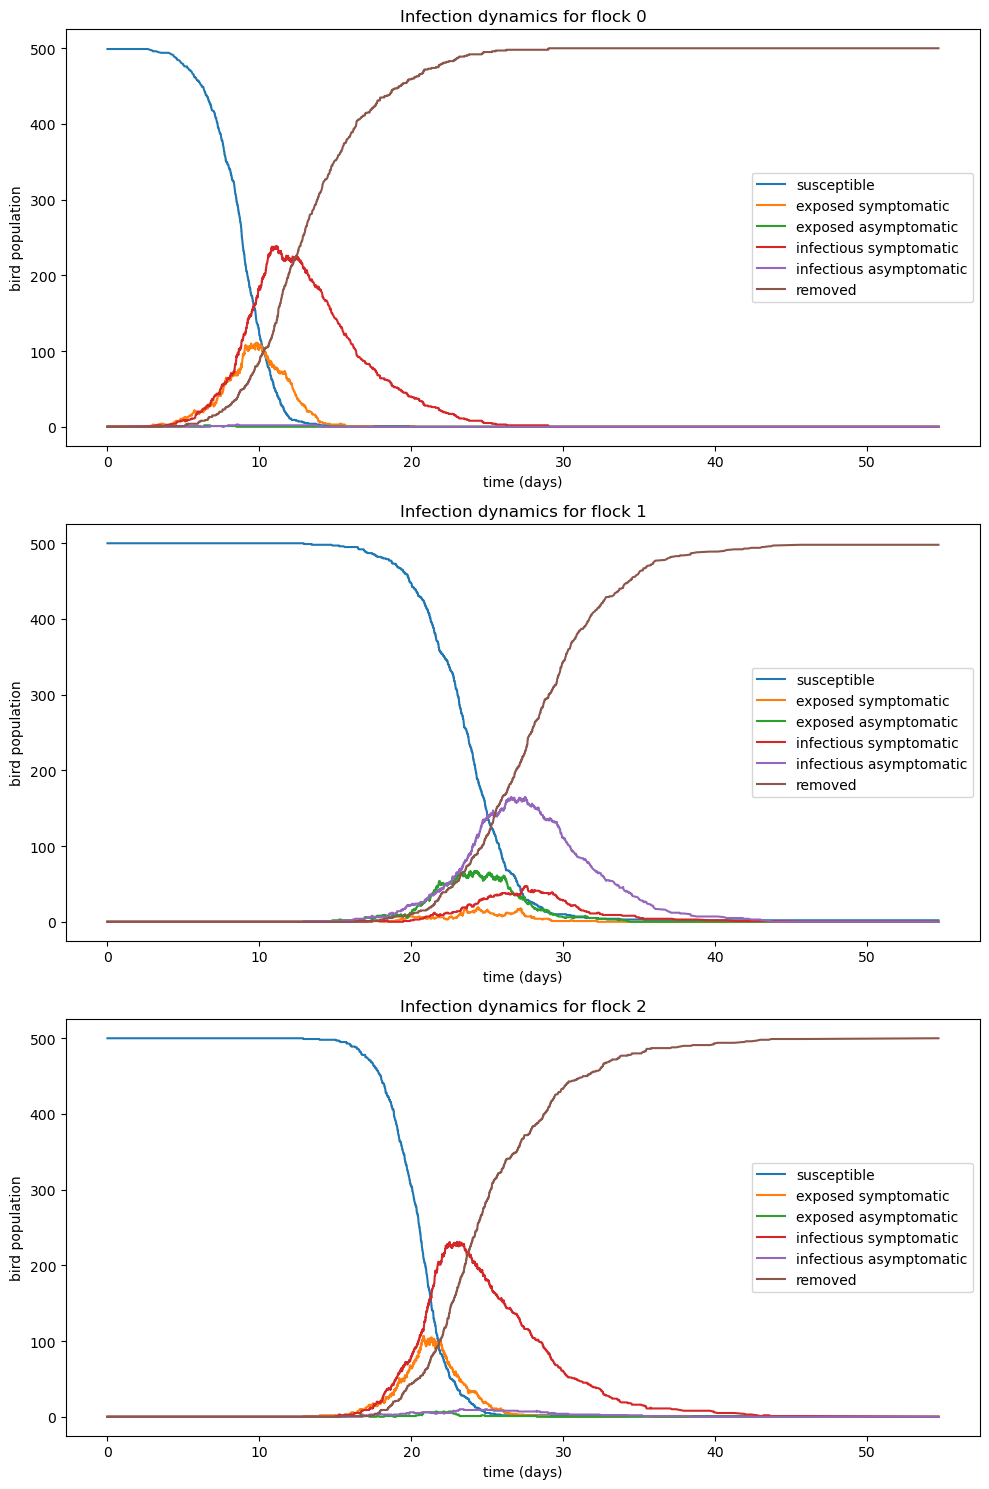

In [7]:
fig, axs = plt.subplots(num_flocks, 1, figsize=(10, 5*num_flocks))

if num_flocks == 1:
    axs = [axs]  # ensure axs is always iterable

for i, ax in enumerate(axs):
    # plot for bird i
    ax.plot(t, y[:, i, 0], label='susceptible')
    ax.plot(t, y[:, i, 1], label='exposed symptomatic')
    ax.plot(t, y[:, i, 2], label='exposed asymptomatic')
    ax.plot(t, y[:, i, 3], label='infectious symptomatic')
    ax.plot(t, y[:, i, 4], label='infectious asymptomatic')
    ax.plot(t, y[:, i, 5], label='removed')
    ax.legend()
    ax.set_xlabel('time (days)')
    ax.set_ylabel('bird population')
    ax.set_title(f'Infection dynamics for flock {i}')

plt.tight_layout()
plt.show()

Record key statistics:
- Whether an outbreak has occurred (Infectious population >= 10 at any point, both the population as a whole and individual flocks).
- Time of outbreak occurrence if there is an outbreak.
- The peak size of the epidemic, and when it occurred (both the population as a whole and individual flocks).
- The final size of the epidemic, and when it finished.

In [8]:
###### Currently work on this cell, continue from here #########


# Record key statistics

######## Outbreak statistics ########
outbreak_threshold = 10

# Outbreak or not
outbreak = len([state for state in y if np.sum(state[:,2]) >= outbreak_threshold]) > 0
outbreak = round(Decimal(outbreak), 2)

# if there is an outbreak, when does it happen
if outbreak:
    outbreak_time = t[[i for i, state in enumerate(y) if np.sum(state[:,2]) >= outbreak_threshold][0]]
    outbreak_time = round(Decimal(outbreak_time), 2)
    print(f'An outbreak has occurred, and it happened on {outbreak_time} days after the first exposure.')
else:
    outbreak_time = None
    print('An outbreak did not occur.')

# Which flocks are invaded by the virus
outbreak_indiv = [len([state for state in y if state[i,2] >= outbreak_threshold]) > 0 for i in range(num_flocks)]
outbreak_time_indiv = [t[[j for j, state in enumerate(y) if np.sum(state[i,2]) >= outbreak_threshold][0]] if outbreak_indiv[i] else None for i in range(num_flocks)]
outbreak_time_indiv = [round(Decimal(i), 2) if i != None else None for i in outbreak_time_indiv]

for i in range(num_flocks):
    if outbreak_indiv[i]:
        print(f'An outbreak in flock {i} occurred after {outbreak_time_indiv[i]} days')
    else:
        print(f'Outbreak did not occur in flock {i}')

An outbreak has occurred, and it happened on 18.21 days after the first exposure.
Outbreak did not occur in flock 0
An outbreak in flock 1 occurred after 19.06 days
Outbreak did not occur in flock 2


In [9]:
######## Peak size for all flocks as a whole ########
peak_size_whole = int(np.max([np.sum(state[:,2]) for state in y]))
peak_time_whole = t[np.argmax([np.sum(state[:,2]) for state in y])]
peak_time_whole = round(Decimal(peak_time_whole), 2)

print(f'The peak of the epidemic occurred after {peak_time_whole} days, with the total peak size {peak_size_whole}.')

######## Individual peak size ########
peak_size_indiv = np.amax([state[:,2] for state in y], axis=0)
peak_size_indiv = [int(i) for i in peak_size_indiv]

peak_time_indiv = [round(Decimal(t[i]), 2) for i in np.argmax([state[:,2] for state in y], axis=0)]

for i in range(num_flocks):
    print(f'The peak for flock {i} occurred after {peak_time_indiv[i]} days, with the flock peak size {peak_size_indiv[i]}')

The peak of the epidemic occurred after 23.13 days, with the total peak size 68.
The peak for flock 0 occurred after 6.36 days, with the flock peak size 2
The peak for flock 1 occurred after 23.89 days, with the flock peak size 67
The peak for flock 2 occurred after 21.61 days, with the flock peak size 7


In [10]:
######## Final size ########
final_size = y[-1][:,-1]
final_size = [int(i) for i in final_size]

end_time = t[-1]
end_time = round(Decimal(end_time), 2)

print(f'After {end_time} days:')
for i in range(num_flocks):
    print(f'the final number of removed birds in flock {i} is {final_size[i]}.')
    

After 54.68 days:
the final number of removed birds in flock 0 is 500.
the final number of removed birds in flock 1 is 498.
the final number of removed birds in flock 2 is 500.
